# Prediction of number of infractions using 1D CNNs
## Notebook Template

This notebook is one of the mandatory deliverables when you submit your solution (alongside the video pitch). Its structure follows the WDL evaluation criteria and it has dedicated cells where you can add descriptions. Make sure your code is readable as it will be the only technical support the jury will have to evaluate your work.

The notebook must:

*   💻 have all the code that you want the jury to evaluate
*   🧱 follow the predefined structure
*   📄 have markdown descriptions where you find necessary
*   👀 be saved with all the output that you want the jury to see
*   🏃‍♂️ be runnable


In [123]:
# Import Libraries
from math import floor

import pandas as pd
import seaborn as sns
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.models import Sequential
from matplotlib import pyplot
from numpy import mean, std
from sklearn.preprocessing import OrdinalEncoder

In [124]:
# O ficheiro é demasiado grande para o github
df = pd.read_csv('/home/fabio/Downloads/parking-tickets-2017-2019_WDL.csv', sep=';', index_col=0,
                 parse_dates=['EntryDate'])
df

/home/fabio/miniconda3/envs/WDL/lib/python3.8/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,Block,Street,EntryDate,Bylaw,Section,Status,InfractionText,Year,HBLOCK
0,1400,Kingsway,2017-08-23,2849,17.1,IS,STOP AT A PLACE WHERE A TRAFFIC SIGN PROHIBITS...,2017,1400 KINGSWAY
1,2100,13th Ave E.,2017-08-26,2849,19.1(H),IS,STOP ON EITHER SIDE OF A LANE WHICH ABUTS COMM...,2017,2100 13TH AVE E
2,2800,Trinity St.,2017-08-26,2849,17.6(B),VA,PARK ON A STREET WHERE A TRAFFIC SIGN RESTRICT...,2017,2800 TRINITY ST
3,200,17th Ave W.,2017-08-27,2849,17.5(B),IS,STOP WITHIN 6 METRES OF THE NEAREST EDGE OF TH...,2017,200 17TH AVE W
4,1900,4th Ave W.,2017-08-19,2952,5(4)(a)(ii),IS,PARK IN A METERED SPACE IF THE PARKING METER H...,2017,1900 4TH AVE W
...,...,...,...,...,...,...,...,...,...
1318730,1000,Smithe St.,2017-04-23,2952,5(4)(a)(ii),IS,PARK IN A METERED SPACE IF THE PARKING METER H...,2017,1000 SMITHE ST
1318731,2500,Yew St.,2017-04-24,2952,5(4)(a)(ii),IS,PARK IN A METERED SPACE IF THE PARKING METER H...,2017,2500 YEW ST
1318732,600,Seymour St.,2017-04-20,2952,5(4)(a)(ii),IS,PARK IN A METERED SPACE IF THE PARKING METER H...,2017,600 SEYMOUR ST
1318733,1300,Robson St.,2017-04-22,2952,5(4)(a)(ii),IS,PARK IN A METERED SPACE IF THE PARKING METER H...,2017,1300 ROBSON ST


## Categorical features

In [127]:
def categorical_feature_study(_df, feature, horizontal=False, treshould=0, plot=True):
    df = _df.copy()
    df = df[feature].value_counts().to_frame()

    if treshould > 0:
        df = df[df[feature] >= treshould]

    df = df.reset_index()
    df = df.rename(columns={feature: "Count"})
    df = df.rename(columns={"index": feature})

    if plot:
        fig, ax = pyplot.subplots()  # figsize=(20,15))

        if horizontal:
            sns.barplot(x="Count", y=feature, data=df, ax=ax)
        else:
            sns.barplot(x=feature, y="Count", data=df, ax=ax)

        ax.plot()

    return df

## Encode categorical features

In [128]:
enc = OrdinalEncoder()
df["InfractionText"] = enc.fit_transform(df[["InfractionText"]]).astype(int)

df_infraction = categorical_feature_study(
    df, "InfractionText", horizontal=True, treshould=10000, plot=False)
df_infraction.head()

,InfractionText,Count
0,21,649308
1,37,144750
2,28,106396
3,30,70446
4,91,42980


In [129]:
enc = OrdinalEncoder()
df["Street"] = enc.fit_transform(df[["Street"]]).astype(int)

df_streets = categorical_feature_study(
    df, "Street", horizontal=True, treshould=10000, plot=False)
df_streets.head()

,Street,Count
0,1688,43603
1,1654,31322
2,806,29818
3,1343,28612
4,1348,28438


## Number of infractions per day

In [130]:
holiday_df = pd.read_csv('holidays.csv', sep=',', parse_dates=['date'])
holiday_df.head(5)

,date,holiday
0,2017-01-01,New Year's Day
1,2017-02-20,Family Day
2,2017-04-14,Good Friday
3,2017-05-22,Victoria Day
4,2017-07-03,Canada Day


,Count
count,1089.000000
mean,1210.959596
std,262.500196
min,1.000000
10%,846.200000
20%,970.600000
30%,1075.400000
40%,1160.200000
50%,1241.000000
60%,1309.800000


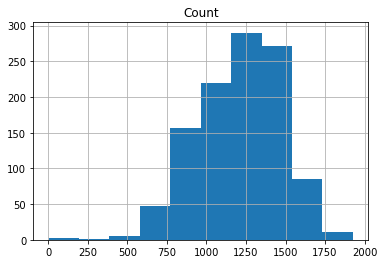

In [131]:
nInfractionsPerDay = df.groupby(['EntryDate']) \
    .count() \
    .rename(columns={'Block': 'Count'})[['Count']] \
    .reset_index()
nInfractionsPerDay["dayOfWeek"] = nInfractionsPerDay.apply(
    lambda row: row.EntryDate.weekday(), axis=1)
nInfractionsPerDay = pd.merge(nInfractionsPerDay, holiday_df, how='left', left_on='EntryDate',
                              right_on='date').drop(columns=['date']).fillna(0, downcast='infer')
nInfractionsPerDay["holiday"] = nInfractionsPerDay.apply(
    lambda row: 0 if row.holiday == 0 else 1, axis=1)

h = nInfractionsPerDay[["Count"]].hist()

nInfractionsPerDay[["Count"]].describe([.1, .2, .3, .4, .5, .6, .7, .8, .9])

## Mapping to categories

- 1 -> Low/No infractions
- 2 -> Some infractions
- 3 -> Average number of infractions
- 4 -> Large number of infractions
- 5 -> Lots of infractions

In [132]:
mapping_dic = {
    1: [0, 970.6],
    2: [970.6, 1160.2],
    3: [1160.2, 1309.8],
    4: [1309.8, 1448.4],
    5: [1448.4, -1]
}


def map_to_cat(num):
    for key, ranges in mapping_dic.items():
        if num >= ranges[0] and (ranges[1] == -1 or num < ranges[1]):
            return key

    print("Negative values not allowed")
    return -1


dfCat = nInfractionsPerDay.copy()
dfCat["countCat"] = dfCat.apply(lambda row: map_to_cat(row.Count), axis=1)

del dfCat["Count"]
dfCat

,EntryDate,dayOfWeek,holiday,countCat
0,2017-01-02,0,0,1
1,2017-01-03,1,0,5
2,2017-01-04,2,0,4
3,2017-01-05,3,0,4
4,2017-01-06,4,0,4
...,...,...,...,...
1084,2019-12-27,4,0,2
1085,2019-12-28,5,0,2
1086,2019-12-29,6,0,1
1087,2019-12-30,0,0,2


In [168]:
def generate_features(df, col, distance=1, count_before=3):
    # Filter rows in which we cannot trace back history
    periodDf = df[df.index-(count_before*distance)>=0].copy()
    # Number of removed elements is the offset for the new df
    n_removed=df.shape[0]-periodDf.shape[0]
    # Add new features based on traced history
    for i in range(0, count_before):
        diff=(i+1)*distance
        periodDf["countCat_minus_" + str(diff)]=periodDf.apply(lambda row: df.iloc[int(row.name)-diff][col], axis=1) 
        
    return periodDf

dfFeatures=generate_features(dfCat, "countCat", distance=7, count_before=2)
dfFeatures

,EntryDate,dayOfWeek,holiday,countCat,countCat_minus_7,countCat_minus_14
14,2017-01-16,0,0,2,3,1
15,2017-01-17,1,0,4,3,5
16,2017-01-18,2,0,4,3,4
17,2017-01-19,3,0,4,3,4
18,2017-01-20,4,0,3,4,4
...,...,...,...,...,...,...
1084,2019-12-27,4,0,2,5,5
1085,2019-12-28,5,0,2,5,4
1086,2019-12-29,6,0,1,2,1
1087,2019-12-30,0,0,2,2,1


## Prediction model

### Objective
#### Predict count category based on previous count categories/holidays and days of the week

### How we do it
#### Consider the last 4 days of the same day of the week
e.g.
- Atual -> 25 of April
- X     -> 4, 11, 18, 25 of Abril for countCat, holiday and dayOfTheWeek
- Y     -> countCat after one week

<AxesSubplot:xlabel='EntryDate', ylabel='Count'>

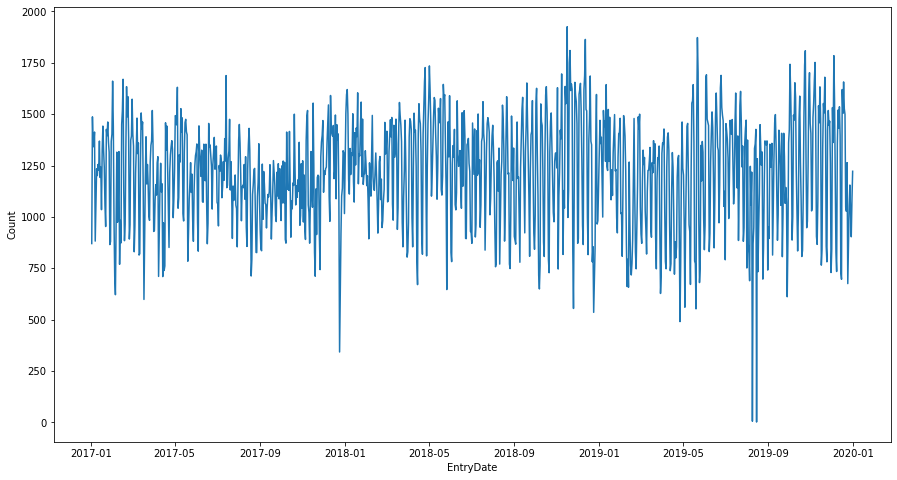

In [133]:
fig, ax = pyplot.subplots(figsize=(15, 8))
sns.lineplot(data=nInfractionsPerDay, x="EntryDate", y="Count", ax=ax)

In [172]:
# load the dataset, returns train and test X and y elements
def load_dataset(df):
    train_size = floor(df.shape[0]*0.8)

    train = df[:train_size]
    test = df[train_size:]

    trainX = train[["countCat", "countCat_minus_7", "countCat_minus_14"]]
    trainY = train[["countCat"]]
    testX = test[["countCat", "countCat_minus_7", "countCat_minus_14"]]
    testY = test[["countCat"]]

    return trainX, trainY, testX, testY


trainX, trainy, testX, testy = load_dataset(dfFeatures)
print(trainX.shape, trainy.shape, testX.shape, testy.shape)

(860, 3) (860, 1) (215, 3) (215, 1)


In [173]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 10, 32
    n_timesteps, n_features, n_outputs = trainX.shape[0], trainX.shape[1], trainy.shape[0]
    print(n_timesteps)
    print(n_features)
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu',
              input_shape=(n_timesteps, n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs,
              batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(
        testX, testy, batch_size=batch_size, verbose=0)
    return accuracy


def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))


def run_experiment(trainX, trainy, testX, testy, repeats=10):
    # repeat experiment
    scores = list()
    for r in range(repeats):
        score = evaluate_model(trainX, trainy, testX, testy)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
    # summarize results
    summarize_results(scores)


run_experiment(trainX, trainy, testX, testy, repeats=1)

860
3


ValueError: in user code:

    /home/fabio/miniconda3/envs/WDL/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/fabio/miniconda3/envs/WDL/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/fabio/miniconda3/envs/WDL/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/fabio/miniconda3/envs/WDL/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/fabio/miniconda3/envs/WDL/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/fabio/miniconda3/envs/WDL/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/fabio/miniconda3/envs/WDL/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /home/fabio/miniconda3/envs/WDL/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/fabio/miniconda3/envs/WDL/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:234 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_6 is incompatible with the layer: : expected min_ndim=3, found ndim=2. Full shape received: (None, 3)
